In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [69]:
train = pd.read_csv('data/raw/train.csv')
test = pd.read_csv('data/raw/test.csv')

In [70]:
# Create a dictionary by combining columns and types
dict(zip(train.columns.to_list(), train.dtypes.to_list()))

{'id': dtype('int64'),
 'timestamp': dtype('O'),
 'full_sq': dtype('int64'),
 'life_sq': dtype('float64'),
 'floor': dtype('float64'),
 'max_floor': dtype('float64'),
 'material': dtype('float64'),
 'build_year': dtype('float64'),
 'num_room': dtype('float64'),
 'kitch_sq': dtype('float64'),
 'state': dtype('float64'),
 'product_type': dtype('O'),
 'sub_area': dtype('O'),
 'area_m': dtype('float64'),
 'raion_popul': dtype('int64'),
 'green_zone_part': dtype('float64'),
 'indust_part': dtype('float64'),
 'children_preschool': dtype('int64'),
 'preschool_quota': dtype('float64'),
 'preschool_education_centers_raion': dtype('int64'),
 'children_school': dtype('int64'),
 'school_quota': dtype('float64'),
 'school_education_centers_raion': dtype('int64'),
 'school_education_centers_top_20_raion': dtype('int64'),
 'hospital_beds_raion': dtype('float64'),
 'healthcare_centers_raion': dtype('int64'),
 'university_top_20_raion': dtype('int64'),
 'sport_objects_raion': dtype('int64'),
 'addition

# 0. Data preprocessing + Feature Engineering

# build_year outliers cleaning

<AxesSubplot:>

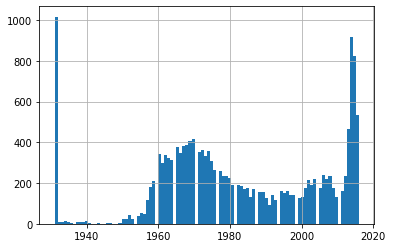

In [71]:
train['build_year'].clip(train['build_year'].quantile(0.06), train['build_year'].quantile(0.99), inplace=True)
train['build_year'].hist(bins=100)

### Product_type (категориальная -> бинарная)

In [72]:
train['product_type'] = train['product_type'].replace({'Investment': 1, 'OwnerOccupier': 0})
test['product_type'] = test['product_type'].replace({'Investment': 1, 'OwnerOccupier': 0})

### New : Price_m2 (Цена за метр квадратный)

In [73]:
train['price_m2'] = train['price_doc'] / (train['full_sq'] + 1)
train['price_m2'].clip(train['price_m2'].quantile(0.01), train['price_m2'].quantile(0.99), inplace=True)

### Каково среднее значение price_m2 в каждой из sub_area (target encoding (sub area))

In [74]:
def target_encoding(train, test, colX, colY):
    col_target_encoding = train.groupby([colX])[colY].mean()
    train[colX] = train[colX].replace(col_target_encoding)
    test[colX] = test[colX].replace(col_target_encoding)
    return train, test

In [75]:
train, test = target_encoding(train, test, 'material', 'price_m2')
train, test = target_encoding(train, test, 'state', 'price_m2')
train, test = target_encoding(train, test, 'sub_area', 'price_m2')

### timestamp encoding // кодирование метки времени

In [76]:
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    timestamp_series = pd.to_datetime(timestamp_series)
    out = pd.DataFrame()

    out['year'] = timestamp_series.dt.year.astype(np.int16)
    out['month'] = timestamp_series.dt.month.astype(np.int8)
    out['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    out['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    
    out['timestamp']= timestamp_series
    out['kseconds'] = timestamp_series.view(int)/1_000_000_000_000
    return out

In [77]:
train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

### add functions

In [78]:
train['floor_height'] = train['floor'] / (train['max_floor'] + 1)
test['floor_height'] = test['floor'] / (test['max_floor'] + 1)

In [79]:
train['kitch_part'] = train['kitch_sq'] / (train['full_sq'] + 1)
train['life_part'] = train['life_sq'] / (train['full_sq'] + 1)

test['life_part'] = test['life_sq'] / (test['full_sq'] + 1)
test['kitch_part'] = test['kitch_sq'] / (test['full_sq'] + 1)

In [80]:
train.loc[:, 'build_year'] = train['build_year'].fillna(train['build_year'].median())
train.loc[:, 'material'] = train['material'].fillna(train['material'].median())
train.loc[:, 'num_room'] = train['num_room'].fillna(train['num_room'].median())
train.loc[:, 'floor_height'] = train['floor_height'].fillna(train['floor_height'].median())
train.loc[:, 'life_part'] = train['life_part'].fillna(train['life_part'].median())
train.loc[:, 'kitch_part'] = train['kitch_part'].fillna(train['kitch_part'].median())
train.loc[:, 'metro_km_walk'] = train['metro_km_walk'].fillna(train['metro_km_walk'].median())
train.loc[:, 'state'] = train['state'].fillna(train['state'].median())

# 1. Cross validation function

In [81]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import SGDRegressor

### features = Xcol , target = Ycol

In [86]:
def cross_validation(df, x_col, y_col):
    features    = x_col
    target      = y_col

    mseList     = []
    msleList    = []
    i = 1

    kf = KFold(n_splits=5, shuffle=True)
    for trainIdx, valIdx in kf.split(df):
        trainPart = df.loc[trainIdx, :]
        valPart = df.loc[valIdx, :]

        model = SGDRegressor()
        model.fit(X=trainPart[features], y=trainPart[target])
        valPred = model.predict(valPart[features]).clip(1, 10**9)

        mse = mean_squared_error(valPred, valPart[target])
        msle = mean_squared_log_error(valPred, valPart[target])

        mseList.append(mse)
        msleList.append(msle)

        print(f'Fold: {i}, MSLE: {msle}, MSE: {mse}')
        i += 1

    print(f'AV_MSLE: {np.mean(msleList)}, AV_MSE: {np.mean(mseList)}')

# 2. Test 5 models

### * Test 1

In [87]:
xCol1 = ['metro_km_walk', 'kremlin_km', 'num_room']
yCol = 'price_m2'

cross_validation(train, xCol1, yCol)

model_1 = SGDRegressor()
model_1.fit(X=train[xCol1], y=train[yCol])

Fold: 1, MSLE: 0.9198168308892423, MSE: 2328065196.270002
Fold: 2, MSLE: 0.36571137035844864, MSE: 2183709294.622018
Fold: 3, MSLE: 0.3484408122910108, MSE: 2205662617.811217
Fold: 4, MSLE: 0.39001663854353413, MSE: 2223981928.871818
Fold: 5, MSLE: 0.3378819282019013, MSE: 2246030005.425536
AV_MSLE: 0.4723735160568275, AV_MSE: 2237489808.600118


SGDRegressor()

2) Test 2

In [88]:
xCol2 = ['metro_km_walk', 'kremlin_km', 'num_room']
yCol = 'price_m2'

train.loc[:, 'metro_km_walk'] = (train['metro_km_walk'] - train['metro_km_walk'].mean()) / train['metro_km_walk'].std()
train.loc[:, 'kremlin_km'] = (train['kremlin_km'] - train['kremlin_km'].mean()) / train['kremlin_km'].std()

cross_validation(train, xCol2, yCol)

model_2 = SGDRegressor()
model_2.fit(X=train[xCol2], y=train[yCol])

Fold: 1, MSLE: 0.3217468009206702, MSE: 2213202809.730272
Fold: 2, MSLE: 0.37925942719155953, MSE: 2177337966.6175156
Fold: 3, MSLE: 0.3885880986532228, MSE: 2141453267.153806
Fold: 4, MSLE: 0.33665271561357585, MSE: 2212153994.4778066
Fold: 5, MSLE: 0.33116703426553423, MSE: 2147701623.194499
AV_MSLE: 0.35148281532891257, AV_MSE: 2178369932.2347803


SGDRegressor()

3) Test 3

In [90]:
xCol3 = ['sub_area',
         'product_type',
         'state',
         'ID_metro',
         'material',
         'num_room',
         'kremlin_km',
         'metro_km_walk']
yCol = 'price_m2'

train.loc[:, 'sub_area'] = (train['sub_area'] - train['sub_area'].mean()) / train['sub_area'].std()
train.loc[:, 'state'] = (train['state'] - train['state'].mean()) / train['state'].std()
train.loc[:, 'ID_metro'] = (train['ID_metro'] - train['ID_metro'].mean()) / train['ID_metro'].std()
train.loc[:, 'material'] = (train['material'] - train['material'].mean()) / train['material'].std()

cross_validation(train, xCol3, yCol)
model_3 = SGDRegressor()
model_3.fit(X=train[xCol3], y=train[yCol])

Fold: 1, MSLE: 0.22286562790538092, MSE: 1759364267.1360211
Fold: 2, MSLE: 0.2303819226789093, MSE: 1743985712.8576276
Fold: 3, MSLE: 0.23626093155075478, MSE: 1829126105.7611794
Fold: 4, MSLE: 0.21743192427913383, MSE: 1720037036.3720155
Fold: 5, MSLE: 0.2272158537574922, MSE: 1779474788.827003
AV_MSLE: 0.2268312520343342, AV_MSE: 1766397582.1907692


SGDRegressor()

4) Test 4

In [91]:
xCol4 = ['sub_area',
         'product_type',
         'state',
         'ID_metro',
         'material',
         'num_room',
         'kremlin_km',
         'metro_km_walk',
        'kseconds',
        'build_year']
yCol = 'price_m2'

train.loc[:, 'kseconds'] = (train['kseconds'] - train['kseconds'].mean()) / train['kseconds'].std()
train.loc[:, 'build_year'] = (train['build_year'] - train['build_year'].mean()) / train['build_year'].std()

cross_validation(train, xCol4, yCol)
model_4 = SGDRegressor()
model_4.fit(X=train[xCol4], y=train[yCol])

Fold: 1, MSLE: 0.2094093465771593, MSE: 1658842199.3380713
Fold: 2, MSLE: 0.21239922991709173, MSE: 1676429170.2099247
Fold: 3, MSLE: 0.22155348613469794, MSE: 1682407298.1809788
Fold: 4, MSLE: 0.22584906461553808, MSE: 1761673641.5491831
Fold: 5, MSLE: 0.22952521702529893, MSE: 1742745146.9486592
AV_MSLE: 0.21974726885395718, AV_MSE: 1704419491.2453635


SGDRegressor()

5) Test 5

In [92]:
xCol5 = ['sub_area',
         'product_type',
         'state',
         'ID_metro',
         'material',
         'num_room',
         'kremlin_km',
         'metro_km_walk',
        'kseconds',
        'build_year']

train['log_price_m2'] = np.log1p(train['price_m2'])

yCol = 'log_price_m2'


cross_validation(train, xCol5, yCol)
model_5 = SGDRegressor()
model_5.fit(X=train[xCol5], y=train[yCol])

Fold: 1, MSLE: 0.001372576323876516, MSE: 0.20295148856121842
Fold: 2, MSLE: 0.001434166087293688, MSE: 0.21200421539988495
Fold: 3, MSLE: 0.001477632800655351, MSE: 0.21863451100726464
Fold: 4, MSLE: 0.0015125280313323156, MSE: 0.22217616204261256
Fold: 5, MSLE: 0.001428320228808012, MSE: 0.21024687574854967
AV_MSLE: 0.0014450446943931766, AV_MSE: 0.21320265055190607


SGDRegressor()

# 3. CV + submit

In [100]:
def write_test(test, model, xCol, i):
    test_prediction = model.predict(test[xCol].fillna(0))

    sample_submission = pd.read_csv('data/raw/sample_submission.csv')

    sample_submission['price_doc'] = test_prediction
    sample_submission['price_doc'] *= test['full_sq']
    sample_submission['price_doc'] = sample_submission['price_doc'].clip(1, 10**9)
    
    sample_submission.to_csv(f'file/predict_hw_model{i}.csv', index=False)

In [101]:
def write_test_logtarget(test, model, x_col, i):
    test_prediction = model.predict(test[x_col].fillna(0))
    sample_submission = pd.read_csv('data/raw/sample_submission.csv')

    sample_submission['price_doc'] = np.e**test_prediction - 1
    sample_submission['price_doc'] *= test['full_sq']
    sample_submission['price_doc'] = sample_submission['price_doc'].clip(1, 10**9)
    
    sample_submission.to_csv(f'file/predict_hw_model{i}.csv', index=False)

In [102]:
test.loc[:, 'metro_km_walk'] = (test['metro_km_walk'] - test['metro_km_walk'].mean()) / test['metro_km_walk'].std()
test.loc[:, 'kremlin_km'] = (test['kremlin_km'] - test['kremlin_km'].mean()) / test['kremlin_km'].std()
test.loc[:, 'sub_area'] = (test['sub_area'] - test['sub_area'].mean()) / test['sub_area'].std()
test.loc[:, 'state'] = (test['state'] - test['state'].mean()) / test['state'].std()
test.loc[:, 'ID_metro'] = (test['ID_metro'] - test['ID_metro'].mean()) / test['ID_metro'].std()
test.loc[:, 'material'] = (test['material'] - test['material'].mean()) / test['material'].std()
test.loc[:, 'kseconds'] = (test['kseconds'] - test['kseconds'].mean()) / test['kseconds'].std()
test.loc[:, 'build_year'] = (test['build_year'] - test['build_year'].mean()) / test['build_year'].std()

In [103]:
write_test(test, model_1, xCol1, 1)
write_test(test, model_2, xCol2, 2)
write_test(test, model_3, xCol3, 3)
write_test(test, model_4, xCol4, 4)
write_test_logtarget(test, model_5, xCol5, 5)

# 4. Plot submit_score(CV_score)

In [1]:
models = ['1', '2', '3', '4', '5']
CV_scores = [0.4723735160568275, 0.35148281532891257, 0.2268312520343342, 0.21974726885395718, 0.0014450446943931766]
submit_scores = [0.35927, 0.34360, 0.33729, 0.36365, 0.50200]

In [2]:
df = pd.DataFrame(list(zip(models, CV_scores, submit_scores)), columns=['model', 'CV', 'submit'])

NameError: name 'pd' is not defined

<AxesSubplot:xlabel='model'>

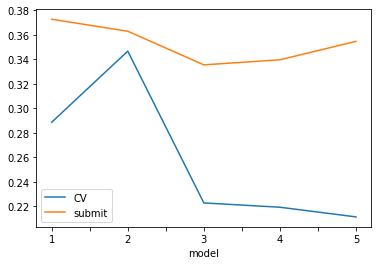

In [106]:
df.plot(x='model', y=['CV', 'submit'])

# 5. Insights

### * Категориальные переменные снизили ошибку
### * Модель переобучается из-за DateTime переменных
### * Логарифмирование таргета ухудшило результат на сабмите